### Downloading the data
We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".

Download the data for January and February 2022.

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_parquet("data/yellow_tripdata_2022-01.parquet")

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [4]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

### Read the data for January. How many columns are there?

In [5]:
len(df.columns)

19

### What's the standard deviation of the trips duration in January?

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

In [6]:
df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]

In [7]:
df.duration = df.duration.apply(lambda x:x.total_seconds() / 60)

In [8]:
df.duration.head()

0    17.816667
1     8.400000
2     8.966667
3    10.033333
4    37.533333
Name: duration, dtype: float64

### Dropping outliers
### What fraction of the records left after you dropped the outliers?

In [9]:
df.duration.describe( percentiles=[0.25,0.90,0.95,0.98])

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
25%      6.316667e+00
50%      1.018333e+01
90%      2.463333e+01
95%      3.193333e+01
98%      4.215000e+01
max      8.513183e+03
Name: duration, dtype: float64

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

In [10]:
df_1_to_60 = df[(df.duration >=1) & (df.duration<=60)]

In [11]:
df_above_60 = df[df.duration >60]

In [12]:
df_above_60.duration.describe()

count    12488.000000
mean       346.752540
std        545.407514
min         60.016667
25%         63.050000
50%         70.950000
75%        119.770833
max       8513.183333
Name: duration, dtype: float64

In [13]:
count_row_df = df.shape[0]
count_row_1_to_60 = df_1_to_60.shape[0]
count_row_above_60 = df_above_60.shape[0]
print(count_row_df, count_row_1_to_60, count_row_above_60)

2463931 2421440 12488


In [14]:
import seaborn as sns

In [15]:
26/100

0.26

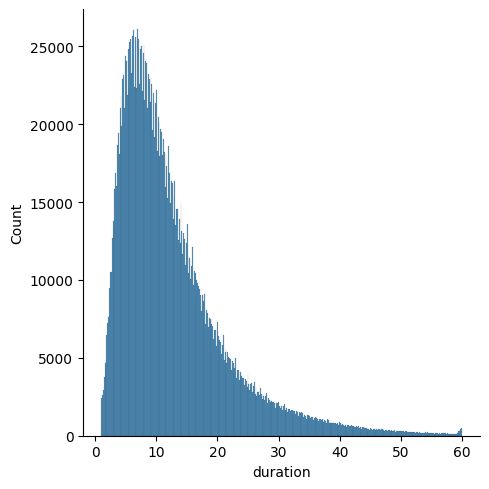

In [16]:
sns.displot(df_1_to_60.duration)

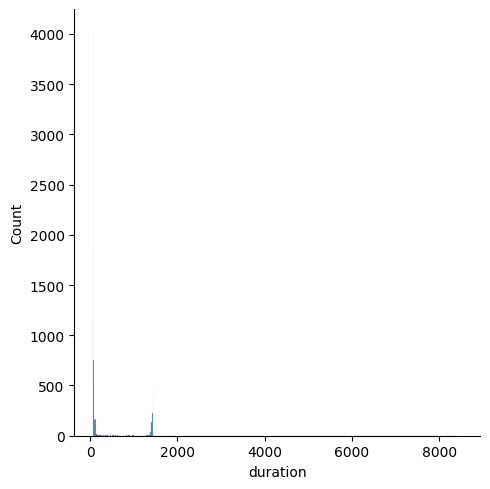

In [17]:
sns.displot(df_above_60.duration)

### One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer
* Get a feature matrix from it

In [18]:
df_model = df_1_to_60[['PULocationID', 'DOLocationID', 'trip_distance','duration']]
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

In [19]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [20]:
df_model[categorical] = df_model[categorical].astype(str)

C:\Users\user\AppData\Local\Temp\ipykernel_9552\337810623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[categorical] = df_model[categorical].astype(str)


In [21]:
train_dicts = df_1_to_60[categorical + numerical].to_dict(orient='records')

In [22]:
train_dicts

[{'PULocationID': 142, 'DOLocationID': 236, 'trip_distance': 3.8},
 {'PULocationID': 236, 'DOLocationID': 42, 'trip_distance': 2.1},
 {'PULocationID': 166, 'DOLocationID': 166, 'trip_distance': 0.97},
 {'PULocationID': 114, 'DOLocationID': 68, 'trip_distance': 1.09},
 {'PULocationID': 68, 'DOLocationID': 163, 'trip_distance': 4.3},
 {'PULocationID': 138, 'DOLocationID': 161, 'trip_distance': 10.3},
 {'PULocationID': 233, 'DOLocationID': 87, 'trip_distance': 5.07},
 {'PULocationID': 238, 'DOLocationID': 152, 'trip_distance': 2.02},
 {'PULocationID': 166, 'DOLocationID': 236, 'trip_distance': 2.71},
 {'PULocationID': 236, 'DOLocationID': 141, 'trip_distance': 0.78},
 {'PULocationID': 141, 'DOLocationID': 229, 'trip_distance': 1.91},
 {'PULocationID': 114, 'DOLocationID': 90, 'trip_distance': 0.82},
 {'PULocationID': 234, 'DOLocationID': 113, 'trip_distance': 0.73},
 {'PULocationID': 246, 'DOLocationID': 79, 'trip_distance': 2.16},
 {'PULocationID': 43, 'DOLocationID': 140, 'trip_distance

In [23]:
from sklearn.feature_extraction import DictVectorizer

In [24]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [25]:
X_train

<2421440x3 sparse matrix of type '<class 'numpy.float64'>'
	with 7264320 stored elements in Compressed Sparse Row format>

In [26]:
X_train.shape

(2421440, 3)

In [27]:
target = 'duration'
y_train = df_1_to_60[target].values

### Training a model

Now let's use the feature matrix from the previous step to train a model.

* Train a plain linear regression model with default parameters
* Calculate the RMSE of the model on the training data

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### What's the RMSE on train?

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
y_pred = lr.predict(X_train)

In [32]:
mean_squared_error(y_train, y_pred, squared=False )

8.920128846479805

### Evaluating the model

Now let's apply this model to the validation dataset (February 2022).

What's the RMSE on validation?

In [34]:
# Read
val_df = pd.read_parquet("data/yellow_tripdata_2022-02.parquet")
# Calculate Duration
val_df["duration"] = val_df["tpep_dropoff_datetime"] - val_df["tpep_pickup_datetime"]
# Duration to Minute
val_df.duration = val_df.duration.apply(lambda x:x.total_seconds() / 60)



In [36]:
# Drop outlier
val_df = val_df[(val_df.duration >=1) & (val_df.duration<=60)]

In [37]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2918187 entries, 0 to 2979430
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [38]:
# One hot Encoding, Make Int to Str
categorical = ['PULocationID', 'DOLocationID']
val_df[categorical] = val_df[categorical].astype(str)
numerical = ['trip_distance']

In [48]:
val_df = val_df[categorical + numerical]

In [50]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2918187 entries, 0 to 2979430
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   PULocationID   object 
 1   DOLocationID   object 
 2   trip_distance  float64
dtypes: float64(1), object(2)
memory usage: 89.1+ MB


In [51]:
# Make Vector Dictionary
val_dicts = val_df.to_dict(orient='records')

In [53]:
dv = DictVectorizer()
# make all features into numpy
X_val  = dv.fit_transform(val_dicts)

In [54]:
X_val

<2918187x515 sparse matrix of type '<class 'numpy.float64'>'
	with 8754561 stored elements in Compressed Sparse Row format>